In [1]:
# Imports and data loading
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
first_150k = pd.read_csv('../input/wine-reviews/winemag-data_first150k.csv', index_col=0)
data_csv = pd.read_csv('../input/wine-reviews/winemag-data-130k-v2.csv', index_col=0)
data_json = pd.read_json('../input/wine-reviews/winemag-data-130k-v2.json')

data = data_csv
target_data = data['points']
feature_data = data.drop('points', axis=1)

## Read the manual
The 'manual' for this data comes in the form of text descriptions on the kaggle site about this data that I have copied and pasted into a txt file, then formatted. 

>Here is a CSV version of the data I scraped. This dataset has three new fields  
--Title (which you can parse the vintage from), Taster Name, and Taster Twitter Handle. This should also fix the duplicate entries problem in the first version of the dataset and add ~25k unique reviews to play with. 

So There are two copies of the dataset, one of which I can see is duplicated in .json form. 

> After watching Somm (a documentary on master sommeliers) I wondered how I could create a predictive model to identify wines through blind tasting like a master sommelier would. The first step in this journey was gathering some data to train a model. I plan to use deep learning to predict the wine variety using words in the description/review. The model still won't be able to taste the wine, but theoretically it could identify the wine based on a description that a sommelier could give. If anyone has any ideas on how to accomplish this, please post them!

So their purpose was similar to mine: pick good wines. 

>winemag-data-130k-v2.csv contains 10 columns and 130k rows of wine reviews.  
winemag-data_first150k.csv contains 10 columns and 150k rows of wine reviews.  
winemag-data-130k-v2.json contains 6919 nodes of wine reviews.

There are three files, one of which is the 'first', and the other two are 'v2', but in different file formats. 

>The data was scraped from WineEnthusiast during the week of June 15th, 2017. The code for the scraper can be found here if you have any more specific questions about data collection that I didn't address.  
**UPDATE 11/24/2017** After feedback from users of the dataset I scraped the reviews again on November 22nd, 2017. This time around I collected the title of each review, which you can parse the year out of, the tasters name, and the taster's Twitter handle. This should also fix the duplicate entry issue.

The data was acquired by web scraping, and then an updated version was scraped that removed some issues with the data. I guess that's what 'first' and 'v2' are referring to. 

>**Inspiration**  
I think that this dataset offers some great opportunities for sentiment analysis and other text related predictive models. My overall goal is to create a model that can identify the variety, winery, and location of a wine based on a description. If anyone has any ideas, breakthroughs, or other interesting insights/models please post them.

Yes. This is a worthy goal. 

>Numeric: unnamed, but functions as a count from 0 ID number  
**String: country**  
The country that the wine is from  
**String: description**  
A few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.  
**String: designation**  
The vineyard within the winery where the grapes that made the wine are from  
**Numeric: points**  
The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)  
**Numeric: price**  
The cost for a bottle of the wine  
**String: province**  
The province or state that the wine is from  
**String: region_1**  
The wine growing area in a province or state (ie Napa)  
**String: region_2**  
Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank  
**String: taster_name**  
Name of the person who tasted and reviewed the wine  
**String: taster_twitter_handle**  
Twitter handle for the person who tasted and reviewed the wine  
**String: title**  
The title of the wine review, which often contains the vintage if you're interested in extracting that feature  
**String: variety**  
The type of grapes used to make the wine (ie Pinot Noir)  
**String: winery**  
The winery that made the wine  

Useful data types and descriptions for the 14 columns. One of them is just an ID column, which I'll incorporate into the dataframe as the index upon loading. The rest are useful looking things, including a freeform text description, name, point score, price, location data, reviewer data (who wrote the description and gave the point score), some text data indicating it's name and year the grapes were picked, the variety of grapes, and the winery that produced the wine. 

Most significantly, above all previous wine-related datasets, these features (besides points and reviewer) are things I can actually find out by reading the label in the shop. This is probably the most useful wine related dataset so far (it's also by far the largest). 

The text data is all freeform and needs to be processed to make it usable. Some needs simple encoding, others require further processing to be useful. 

## Basics
What does the data look like?  
How much of it is there?  
What type of data is it? 

In [3]:
first_150k.sample(5, random_state=4)

,country,description,designation,points,price,province,region_1,region_2,variety,winery
31034,US,"The aromas seem a bit muddled, with notes of j...",Colter's Creek Estate,84,10.0,Idaho,Idaho,NaN,Riesling,Colter's Creek
58,US,Cabernet makes up just over half of this blend...,Final Final,90,30.0,Washington,Columbia Valley (WA),Columbia Valley,Cabernet Sauvignon-Syrah,Efeste
24657,Italy,"Le Macchiole's Bolgheri Rosso blend (Merlot, C...",NaN,90,30.0,Tuscany,Bolgheri,NaN,Red Blend,Le Macchiole
139801,Italy,"A special, gentle wine with caressing persiste...",NaN,92,60.0,Tuscany,Brunello di Montalcino,NaN,Sangiovese,Fornacina
1820,US,Winemaker Nick Goldschmidt does wonders with t...,Lone Tree Vineyard,90,50.0,California,Alexander Valley,Sonoma,Cabernet Sauvignon,Forefathers


The first data collected has fewer columns, but is otherwise as described. Since I've already decided not to use the old data, and to work with the more recently collected data (that also has more features), I will not analyse this any further. 

In [4]:
data_csv.sample(5, random_state=4)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
105424,France,Steinbach is a village at the extreme southern...,Steinbach,90,35.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Joseph Cattin 2010 Steinbach Pinot Noir (Alsace),Pinot Noir,Joseph Cattin
30811,US,"Salted lemon rinds, ice-cold apple, fresh-sque...",Bien Nacido Vineyard Block II Mount Eden Clone,92,46.0,California,Santa Maria Valley,Central Coast,Matt Kettmann,@mattkettmann,Scar of the Sea 2013 Bien Nacido Vineyard Bloc...,Chardonnay,Scar of the Sea
86983,Italy,"Delicately scented, this offers subtle aromas ...",Occhi di Ciumi,89,20.0,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Al-Cantàra 2015 Occhi di Ciumi (Etna),White Blend,Al-Cantàra
109619,US,"As sweet as angel food cake, with sugary vanil...",NaN,82,14.0,California,Central Coast,Central Coast,NaN,NaN,Cupcake 2008 Chardonnay (Central Coast),Chardonnay,Cupcake
98442,France,"Very dense and firm, this has powerful tannins...",NaN,94,NaN,Bordeaux,Pessac-Léognan,NaN,Roger Voss,@vossroger,Château Smith Haut Lafitte 2009 Pessac-Léognan,Bordeaux-style Red Blend,Château Smith Haut Lafitte


The features all seem to be as described. Notably, the points are in integers and price is in decimals. Also, in this random sample of 5 rows I can already see seven data are missing. Much of the longer text data is inconsistent in structure, though all seem to have a year (vintage) which - if present in enough of them - could be useful for determining the age of the wine. Relevantly, the reviews were scraped on 22/02/2017. 

In [5]:
data_json.sample(5, random_state=4)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
105424,France,Steinbach is a village at the extreme southern...,Steinbach,90,35.0,Alsace,Alsace,None,Roger Voss,@vossroger,Joseph Cattin 2010 Steinbach Pinot Noir (Alsace),Pinot Noir,Joseph Cattin
30811,US,"Salted lemon rinds, ice-cold apple, fresh-sque...",Bien Nacido Vineyard Block II Mount Eden Clone,92,46.0,California,Santa Maria Valley,Central Coast,Matt Kettmann,@mattkettmann,Scar of the Sea 2013 Bien Nacido Vineyard Bloc...,Chardonnay,Scar of the Sea
86983,Italy,"Delicately scented, this offers subtle aromas ...",Occhi di Ciumi,89,20.0,Sicily & Sardinia,Etna,None,Kerin O’Keefe,@kerinokeefe,Al-Cantàra 2015 Occhi di Ciumi (Etna),White Blend,Al-Cantàra
109619,US,"As sweet as angel food cake, with sugary vanil...",None,82,14.0,California,Central Coast,Central Coast,None,None,Cupcake 2008 Chardonnay (Central Coast),Chardonnay,Cupcake
98442,France,"Very dense and firm, this has powerful tannins...",None,94,NaN,Bordeaux,Pessac-Léognan,None,Roger Voss,@vossroger,Château Smith Haut Lafitte 2009 Pessac-Léognan,Bordeaux-style Red Blend,Château Smith Haut Lafitte


Immediately, this data looks the same as `data_csv`, except that 'NaN' is replaced by 'None' in the cases of missing data. 

In [6]:
data_json.equals(data_csv)

True

They are exactly the same, and the 'NaN'-'None' difference is a formatting difference between csv and json data. I can safely disregard `data_json`. This leaves a single data file, in CSV format, left to continue with. 

In [7]:
data_csv.shape

(129971, 13)

With 13 features and 129,971 samples, there are 1,689,623 pices of data. 
- **country**: String. Nominal categorical. 
- **description**: String. Freeform text. 
- **designation**: String. Freeform text. 
- **points**: Numeric. Integer ratio. 
- **price**: Numeric. Continuous ratio. 
- **province**: String. Nominal categorical. 
- **region_1**: String. Nominal categorical. 
- **region_2**: String. Nominal categorical. 
- **taster_name**: String. Nominal categorical. 
- **taster_twitter_handle**. String. Nominal categorical. 
- **title**: String. Freeform text. Contains an integer interval datum that could be parsed. 
- **variety**: String. Nominal categorical. 
- **winery**: String. Nominal categorical. 

## Target variable
Datatype?  
Descriptive statistics?  
Unbalanced? Does it need weighting?  
Is it linearly separable?  
What sorts of models can predict this?  

The target variable is `points`. It's data type is integer ratio. 

In [8]:
# Descriptive statistics
target_data.describe()

count    129971.000000
mean         88.447138
std           3.039730
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

There is no missing data in the target variable. There are also no scores below 80, which on a 0-100 score system would be farcical - I imagine the dataset was gathered explicitly excluding wines with point scores below that threshold? 

Having just read the code that scraped the website, I've found that it was hardcoded to scrape all the pages of reviews that were there at the time. I then went to the website itself; [ https://www.winemag.com/?s=&drink_type=wine&page=1&sort_by=rating&sort_dir=asc ], and discoverd that of 249,314 reiviews, only two were below 80. One is 22 points, and the other is 44 and marked as a duplicate. 

As I read further, I found this explanation of their ratings (table headers and formatting added by me): 

>| Score range | Quality | Description |
>|---|---|---|
>| 98–100 | Classic | The pinnacle of quality. |
>| 94–97 | Superb | A great achievement. |
>| 90–93 | Excellent | Highly recommended. |
>| 87–89 | Very Good | Often good value; well recommended. |
>| 83–86 | Good | Suitable for everyday consumption; often good value. |
>| 80–82 | Acceptable | Can be employed in casual, less-critical circumstances. |
>
>Products deemed Unacceptable (receiving a rating below 80 points) are not reviewed.

Which explains this completely. I don't know why the two sub-80 reviews aren't in this dataset, but they're clearly anomalies and I will discount them. 

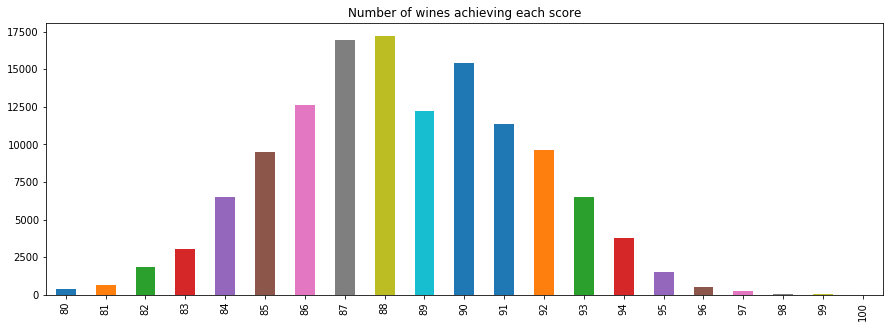

In [9]:
target_data.value_counts().sort_index().plot.bar(title='Number of wines achieving each score', figsize=(15,5))

In [10]:
stats_describe_target = stats.describe(target_data)
print('Target data skewness: {}'.format(stats_describe_target.skewness))
print('Target data kurtosis: {}'.format(stats_describe_target.kurtosis))

Target data skewness: 0.04592022248056047
Target data kurtosis: -0.29599796801102096


These skewness and kurtosis scores make sense, and the distribution of the target variable does look rather like a normal distribution, give or take. 

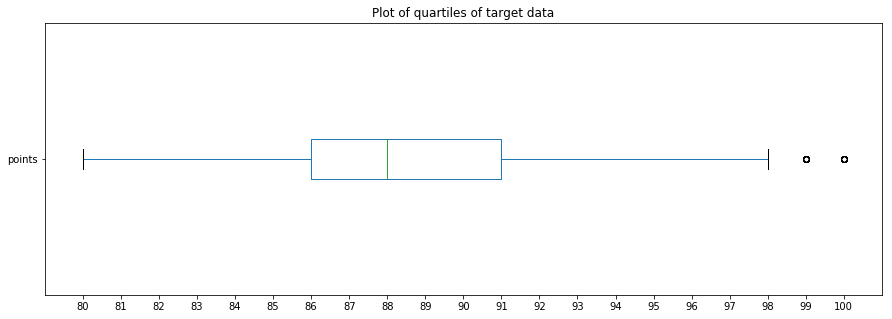

In [11]:
ax = target_data.plot.box(title='Plot of quartiles of target data', figsize=(15,5), vert=False)
ax.set_xticks(target_data.value_counts().sort_index().index);

This boxplot shows that despite the distribution being fairly normal, it does have outliers. Since they're everything above 98, I'll check how many there are: 

In [12]:
target_data[target_data>98].size

52

Apparently there are 52 suspected outliers in this dataset, which out of 129,971, isn't many. Unless there's a specific reason to remove them, I'll leave them in, and consider any further engineering of them when I have more context, if necessary. 

Seeing as how this data is integer ratio data, it is evidently linearly separable. I will consider using regression models to make predictive models for this. 

## Feature data
### Numeric
Independent or dependent?  
What are the descriptive statistics of the data?  
Is it sparse or dense?  
How much of it is missing?  

Some of the features are independent of each other, in so far as anything in the physical universe is independent of anything else, though several are not. taster_name and taster_twitter_handle, which seem to share some similarity, for obvious reasons. It is likely that one of these will be dropped before the analysis, because it's duplicate information. 

In [13]:
feature_data.describe()

,price
count,120975.000000
mean,35.363389
std,41.022218
min,4.000000
25%,17.000000
50%,25.000000
75%,42.000000
max,3300.000000


Since price is the only numerical feature variable, `pd.describe()` has limited use.  
That said, looking at this shows some interesting things: the standard deviation is larger than the mean for a continuous ratio variable, and three percentiles, as well as the standard deviation and the mean, are all two orders of magnitude smaller than the max value. I'd like to see what a boxplot labels as suspected outliers: 

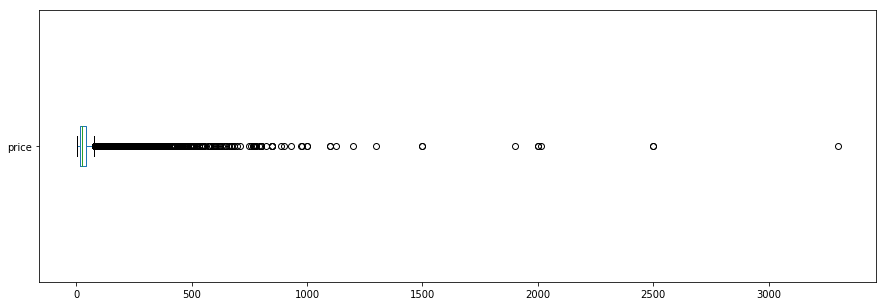

In [14]:
feature_data.price.plot.box(x='price', figsize=(15,5), vert=False)

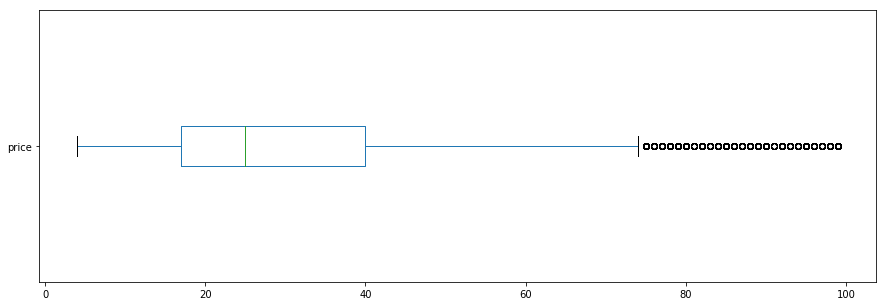

In [15]:
feature_data[feature_data.price<100].price.plot.box(x='price', figsize=(15,5), vert=False)

That's a huge part of the range that's outlier territory, from 72 to 3000+. 

In [16]:
feature_data[feature_data.price>=72].shape

(9284, 12)

9284/129971=0.07, which make 7% of the price feature outliers. That's a large amount. 

In [17]:
feature_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 12 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), object(11)
memory usage: 12.9+ MB


Of the features; 
- country
- description
- province
- title
- variety
- winery 
appear to be mostly non-null data, whereas; 
- designation
- price
- region_1
- taster_name